<a id="loading"></a>
#     NEURAL NETWORKS AND DEEP LEARNING FOR FINANCE                         #
###                  Autumn 2020                               #

##                          Lab Exercise  2:                                               #
##                         Titanic challenge part with Deep Learning                                               #

 ###    This lab exercise is the solution of  Titanic challenge with apply Deep Learning model
 ##           The code based on  notebook from 
###           You don't need submit your solution to this lab excercise.

<a id="loading"></a>
# 1. Load packages and data

In [4]:
# import some packages, later, you will need to import more packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams



In [ ]:
#Install Keras, you need to install keras pacakge

In [5]:
pip install keras

In [ ]:
#TensorFlow installation

In [6]:
pip install tensorflow

In [7]:

import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from numpy.random import seed
#from tensorflow import set_random_seed
import tensorflow
tensorflow.random.set_seed(0)



In [ ]:
#make sure you have saved dataset file beside code files, otherwise you need to address the working directory 

In [8]:
# Load data as Pandas dataframe
train = pd.read_csv('train_clean.csv', )
test = pd.read_csv('test_clean.csv')
df = pd.concat([train, test], axis=0, sort=True)

In [9]:
df.head()

,Age,Cabin,Embarked,Family_Size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,0,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [10]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309,NaN,NaN,NaN,29.5624,13.1654,0.17,22,30,35.5,80
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Family_Size,1309,NaN,NaN,NaN,0.883881,1.58364,0,0,0,1,10
Fare,1309,NaN,NaN,NaN,33.2762,51.7436,0,7.8958,14.4542,31.275,512.329
Name,1309,1307,"Kelly, Mr. James",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309,NaN,NaN,NaN,0.385027,0.86556,0,0,0,0,9
PassengerId,1309,NaN,NaN,NaN,655,378.02,1,328,655,982,1309
Pclass,1309,NaN,NaN,NaN,2.29488,0.837836,1,2,3,3,3
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id="pre-processing"></a>
# 2. Pre-processing
<a id="encoding"></a>
## 2.1. Encode Categorical Variables
We need to convert all categorical variables into numeric format. The categorical variables we will be keeping are `Embarked`, `Sex` and `Title`.   

The `Sex` variable can be encoded into single 1-or-0 column, but the other variables will need to be [one-hot encoded](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). Regular label encoding assigns some category labels higher numerical values. This implies some sort of scale (Embarked = 1 is not **more** than Embarked = 0 - it's just _different_). One Hot Encoding avoids this problem.   

We will assume that there is some ordinality in the `Pclass` variable, so we will leave that as a single column.

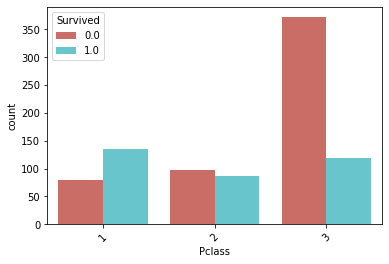

In [11]:
sns.countplot(x='Pclass', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

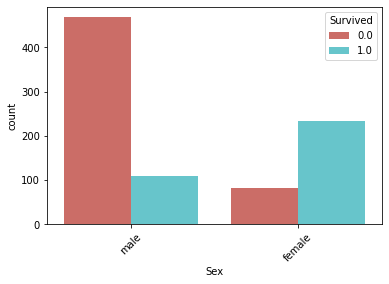

In [12]:
sns.countplot(x='Sex', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

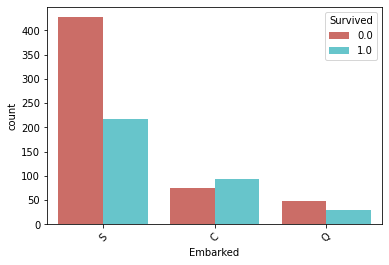

In [13]:
sns.countplot(x='Embarked', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [14]:
# convert to cateogry dtype
df['Sex'] = df['Sex'].astype('category')
# convert to category codes
df['Sex'] = df['Sex'].cat.codes

In [15]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked', 'Title']

for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [16]:
# drop the variables we won't be using
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [17]:
df.head()

,Age,Family_Size,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,22.0,1,7.2500,0,3,1,1,0.0,0,0,1,0,0,0,1,0,0
1,38.0,1,71.2833,0,1,0,1,1.0,1,0,0,0,0,0,0,1,0
2,26.0,0,7.9250,0,3,0,0,1.0,0,0,1,0,0,1,0,0,0
3,35.0,1,53.1000,0,1,0,1,1.0,0,0,1,0,0,0,0,1,0
4,35.0,0,8.0500,0,3,1,0,0.0,0,0,1,0,0,0,1,0,0


## 2.2. Scale Continuous Variables
The continuous variables need to be scaled. This is done using a standard scaler from SkLearn.

In [20]:
from sklearn.preprocessing import StandardScaler

continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']

scaler = StandardScaler()

for var in continuous:
    df[var] = df[var].astype('float64')
    df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))

In [21]:
## we will define the following function, where we set max.rows and max.columns to 1000.
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [22]:
display_all(df.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
Age,1309.0,1.306145e-16,1.000382,-2.233408,-0.574635,0.033252,0.451175,3.832549
Family_Size,1309.0,2.593630e-16,1.000382,-0.558346,-0.558346,-0.558346,0.073352,5.758637
Fare,1309.0,-6.780927e-17,1.000382,-0.643344,-0.490691,-0.363894,-0.038690,9.261749
Parch,1309.0,-8.549311e-17,1.000382,-0.445000,-0.445000,-0.445000,-0.445000,9.956864
Pclass,1309.0,-3.901471e-17,1.000382,-1.546098,-0.352091,0.841916,0.841916,0.841916
Sex,1309.0,6.440031e-01,0.478997,0.000000,0.000000,1.000000,1.000000,1.000000
SibSp,1309.0,-6.375937e-16,1.000382,-0.479087,-0.479087,-0.479087,0.481288,7.203909
Survived,891.0,3.838384e-01,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Embarked_C,1309.0,2.070283e-01,0.405331,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,1309.0,9.396486e-02,0.291891,0.000000,0.000000,0.000000,0.000000,1.000000


<a id="neural-network"></a>
# 3. Neural Network
Now, all that is left is to feed our data that has been cleaned, encoded and scaled to our neural network.

But first, we need to separate *data_df* back into *train* and *test* sets.

In [23]:
X_train = df[pd.notnull(df['Survived'])].drop(['Survived'], axis=1)
y_train = df[pd.notnull(df['Survived'])]['Survived']
X_test = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

3.0 Create a simple model

The following code builds a simple deep learning model:

In [24]:
     # step 1
    # set random seed for reproducibility
seed(42)
    # set_random_seed(42)
tensorflow.random.set_seed(42)
    # step 2 #
    # create a sequential model
      
mymodel = Sequential()
    
    # create first hidden layer
mymodel.add(Dense(11, input_dim=X_train.shape[1], activation='linear'))
    
    # create additional hidden layer
mymodel.add(Dense(10, activation='linear'))
    
    # add dropout, default is none
#    model.add(Dropout(dr))
    
    # create output layer
mymodel.add(Dense(1, activation='sigmoid'))  # output layer
    
  #  mymodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


Loss function and optimizing function should be specified

In [25]:
mymodel.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [26]:
print(mymodel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                187       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 318
Trainable params: 318
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#training.history

Fit the model and check the accuracy of the model

In [27]:
# train model on full train set, with 80/20 CV split
training = mymodel.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 87.83%


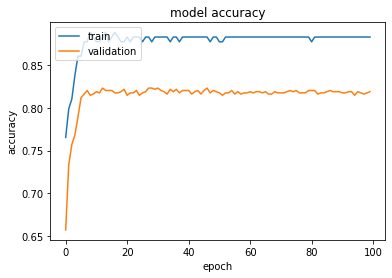

In [28]:
# summarize history for accuracy
plt.plot(training.history['val_accuracy'])
plt.plot(training.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#*****************************************************
######### Try to improve the model
Add another layer and check the model


In [ ]:
# calculate predictions
test['Survived'] = mymodel.predict(X_test)
test['Survived'] = test['Survived'].apply(lambda x: round(x,0)).astype('int')
solution = test[['PassengerId', 'Survived']]
solution

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
mymodel = Sequential()
    
    # create first hidden layer
mymodel.add(Dense(1, input_dim=X_train.shape[1], activation='linear'))

mymodel.add(Dense(10, activation='linear'))
mymodel.add(Dense(10, activation='linear'))
mymodel.add(Dense(10, activation='linear')) # the third layer (added) (New)

mymodel.add(Dense(1, activation='sigmoid'))  # output layer


val_acc: 83.74%


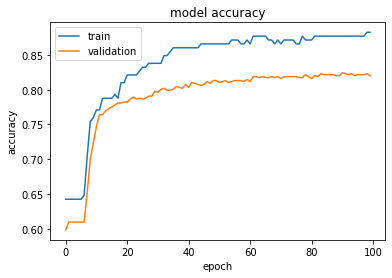

In [ ]:
mymodel.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
training = mymodel.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))
# summarize history for accuracy
plt.plot(training.history['val_accuracy'])
plt.plot(training.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# change batch size and epochs

In [ ]:
mymodel.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
training = mymodel.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=0)
val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))
# summarize history for accuracy
plt.plot(training.history['val_accuracy'])
plt.plot(training.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


val_acc: 88.26%


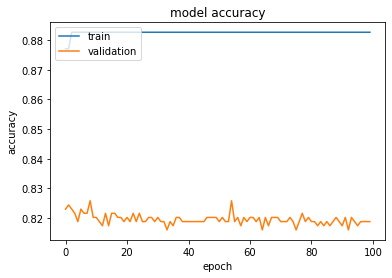

In [ ]:
mymodel.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
training = mymodel.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=0)
val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))
# summarize history for accuracy
plt.plot(training.history['val_accuracy'])
plt.plot(training.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

To improve the model, apply Dropout with 20%

In [ ]:
mymodel = Sequential()
    
    # create first hidden layer
mymodel.add(Dense(1, input_dim=X_train.shape[1], activation='linear'))

mymodel.add(Dense(10, activation='linear'))
mymodel.add(Dense(10, activation='linear'))
mymodel.add(Dense(10, activation='linear')) # the third layer (added) (New)

# add dropout, default is none
mymodel.add(Dropout(0.2))
    
mymodel.add(Dense(1, activation='sigmoid'))  # output layer

In [ ]:
mymodel.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
training = mymodel.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2, verbose=0)
val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))
# summarize history for accuracy
plt.plot(training.history['val_accuracy'])
plt.plot(training.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

***********************************************************
Find the best model

## 3.1. Cross-validation
Keras allows us to make use of cross-validation for training our model. So we will use this to train and assess our first model.

### Create neural network model
For this task, I have kept the model architecture pretty simple. We have one input layer with 17 nodes which feeds into a hidden layer with 8 nodes and an output layer which is used to predict a passenger's survival.   

The output layer has a sigmoid activation function, which is used to 'squash' all our outputs to be between 0 and 1.   

We are going to create a function which allows to parameterise the choice of hyperparameters in the neural network. This might seem a little overly complicated now, but it will come in super handy when we move onto tuning our parameters later.

In [ ]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    
    # set random seed for reproducibility
    seed(42)
  # set_random_seed(42)
    tensorflow.random.set_seed(42)
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [ ]:
model = create_model()

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
None


### Train model
At this stage, we have our model. We have chosen a few hyperparameters such as the number of hidden layers, the number of neurons and the activation function.

The next step is to train the model on our training set. This step also requires us to choose a few more hyperparameters such as the loss function, the optimization algorithm, the number of epochs and the batch size.

In [ ]:
# train model on full train set, with 80/20 CV split
training = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 86.53%


In [ ]:
#training.history

### Assess results

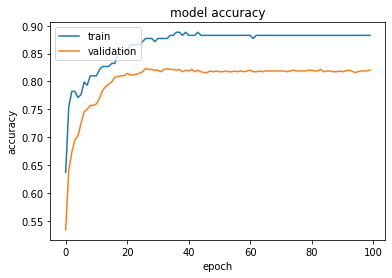

In [ ]:
# summarize history for accuracy
plt.plot(training.history['val_accuracy'])
plt.plot(training.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 3.2. Grid search
### 3.2.1. batch size and epochs
We can see from the graph above that we might be training our network for too long. Let's use **grid search** to find out what the optimal values for `batch_size` and `epochs` are.

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# search the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=3,
                    verbose=2)  # include n_jobs=-1 if you are using CPU

grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] batch_size=16, epochs=50 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... batch_size=16, epochs=50, total=   3.9s
[CV] batch_size=16, epochs=50 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] ......................... batch_size=16, epochs=50, total=   3.8s
[CV] batch_size=16, epochs=50 ........................................
[CV] ......................... batch_size=16, epochs=50, total=   4.0s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........................ batch_size=16, epochs=100, total=   6.8s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........................ batch_size=16, epochs=100, total=   7.1s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........................ batch_size=16, epochs=100, total=   6.7s
[CV] batch_size=32, epochs=50 ........................................
[CV] ......................... batch_size=32, epochs=50, total=   2.4s
[CV] batch_size=32, epochs=50 ........................................
[CV] ......................... batch_size=32, epochs=50, total=   2.3s
[CV] batch_size=32, epochs=50 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.1min finished


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.822671 using {'batch_size': 32, 'epochs': 50}
0.817059 (0.012992) with: {'batch_size': 16, 'epochs': 50}
0.814815 (0.014547) with: {'batch_size': 16, 'epochs': 100}
0.822671 (0.008837) with: {'batch_size': 32, 'epochs': 50}
0.813692 (0.018305) with: {'batch_size': 32, 'epochs': 100}
0.818182 (0.015307) with: {'batch_size': 64, 'epochs': 50}
0.814815 (0.014547) with: {'batch_size': 64, 'epochs': 100}


### 3.2.2. Optimization Algorithm

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
param_grid = dict(opt=optimizer)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

C:\Users\amirhossein.sadoghi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] opt=SGD .........................................................
[CV] .......................................... opt=SGD, total=   1.9s
[CV] opt=SGD .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] .......................................... opt=SGD, total=   2.0s
[CV] opt=SGD .........................................................
[CV] .......................................... opt=SGD, total=   1.9s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   2.1s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   2.1s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   2.2s
[CV] opt=Adagrad .....................................................
[CV] ...................................... opt=Adagrad, total=   2.3s
[CV] opt=Adagrad .....................................................
[CV] ...................................... opt=Adagrad, total=   2.1s
[CV] opt=Adagrad .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   41.1s finished


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.822671 using {'opt': 'Adam'}
0.810325 (0.020997) with: {'opt': 'SGD'}
0.820426 (0.010408) with: {'opt': 'RMSprop'}
0.814815 (0.015307) with: {'opt': 'Adagrad'}
0.821549 (0.011983) with: {'opt': 'Adadelta'}
0.822671 (0.008837) with: {'opt': 'Adam'}
0.815937 (0.014108) with: {'opt': 'Nadam'}


### 3.2.3. Hidden neurons

In [ ]:
#seed(42)
#set_random_seed(42)

# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
layers = [[8],[10],[10,5],[12,6],[12,8,4]]
param_grid = dict(lyrs=layers)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] lyrs=[8] ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................................... lyrs=[8], total=   2.2s
[CV] lyrs=[8] ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ......................................... lyrs=[8], total=   2.4s
[CV] lyrs=[8] ........................................................
[CV] ......................................... lyrs=[8], total=   2.4s
[CV] lyrs=[10] .......................................................
[CV] ........................................ lyrs=[10], total=   2.4s
[CV] lyrs=[10] .......................................................
[CV] ........................................ lyrs=[10], total=   2.5s
[CV] lyrs=[10] .......................................................
[CV] ........................................ lyrs=[10], total=   2.4s
[CV] lyrs=[10, 5] ....................................................
[CV] ..................................... lyrs=[10, 5], total=   2.7s
[CV] lyrs=[10, 5] ....................................................
[CV] ..................................... lyrs=[10, 5], total=   2.8s
[CV] lyrs=[10, 5] ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   39.7s finished


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.822671 using {'lyrs': [8]}
0.822671 (0.008837) with: {'lyrs': [8]}
0.822671 (0.008837) with: {'lyrs': [10]}
0.820426 (0.015141) with: {'lyrs': [10, 5]}
0.822671 (0.013561) with: {'lyrs': [12, 6]}
0.818182 (0.016722) with: {'lyrs': [12, 8, 4]}


### 3.2.4. Dropout

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
param_grid = dict(dr=drops)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] dr=0.0 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... dr=0.0, total=   2.6s
[CV] dr=0.0 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] ........................................... dr=0.0, total=   2.4s
[CV] dr=0.0 ..........................................................
[CV] ........................................... dr=0.0, total=   2.4s
[CV] dr=0.01 .........................................................
[CV] .......................................... dr=0.01, total=   2.6s
[CV] dr=0.01 .........................................................
[CV] .......................................... dr=0.01, total=   2.6s
[CV] dr=0.01 .........................................................
[CV] .......................................... dr=0.01, total=   2.6s
[CV] dr=0.05 .........................................................
[CV] .......................................... dr=0.05, total=   3.0s
[CV] dr=0.05 .........................................................
[CV] .......................................... dr=0.05, total=   2.7s
[CV] dr=0.05 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   48.2s finished


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.824916 using {'dr': 0.2}
0.822671 (0.008837) with: {'dr': 0.0}
0.822671 (0.014108) with: {'dr': 0.01}
0.823793 (0.015632) with: {'dr': 0.05}
0.823793 (0.015632) with: {'dr': 0.1}
0.824916 (0.017168) with: {'dr': 0.2}
0.819304 (0.018305) with: {'dr': 0.5}


In [ ]:
# create final model
model = create_model(lyrs=[8], dr=0.2)

print(model.summary())

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_76 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_178 (Dense)            (None, 1)                 9         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# train model on full train set, with 80/20 CV split
training = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                     validation_split=0.2, verbose=0)

# evaluate the model
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

891/891 [==============================] - 0s 22us/step

accuracy: 83.16%


In [ ]:
#training.history

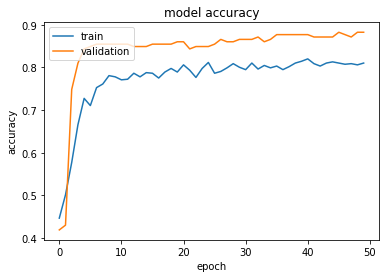

In [ ]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 3.3. Make Predictions on Test Set
Finally, we can attempt to predict which passengers in the test set survived.

In [ ]:
# calculate predictions
test['Survived'] = model.predict(X_test)
test['Survived'] = test['Survived'].apply(lambda x: round(x,0)).astype('int')
solution = test[['PassengerId', 'Survived']]

In [ ]:
solution.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


## 3.4. Output Final Predictions

In [ ]:
#solution.to_csv("Neural_Network_Solution.csv", index=False)